## Time Series Forecasting using XGBoost

In [1]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [2]:
import numpy as np # linear algebra
import pandas as pd
from xgboost import plot_importance, plot_tree
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10')




In [ ]:
!pip install xgboost

In [3]:
import os
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [4]:
query = """
SELECT * FROM `ironhacks-data.ironhacks_training.weather_data`
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()
df.head()

,date,max_rel_humidity,max_temperature,mean_temperature,min_rel_humidity,min_temperature,potential_water_deficit,precipitation_data,wind_speed
0,2019-08-10,90.5813,28.3985,21.5126,39.8397,14.6268,-4.8887,0.0,2.1004
1,2019-08-24,91.3571,24.6652,18.6607,44.4712,12.6562,-4.7381,0.0,4.4706
2,2019-08-28,93.9562,25.3146,18.8246,43.4746,12.3346,-4.7147,0.0,4.3852
3,2019-09-04,99.9498,25.4570,18.6242,56.4720,11.7913,-3.6142,0.0,3.6461
4,2019-09-17,96.1398,26.9347,20.6516,46.6763,14.3685,-4.1923,0.0,4.0712


## Data Pre-Processing

In [5]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df

,date,max_rel_humidity,max_temperature,mean_temperature,min_rel_humidity,min_temperature,potential_water_deficit,precipitation_data,wind_speed,year,month
0,2019-08-10,90.5813,28.3985,21.5126,39.8397,14.6268,-4.8887,0.0000,2.1004,2019,8
1,2019-08-24,91.3571,24.6652,18.6607,44.4712,12.6562,-4.7381,0.0000,4.4706,2019,8
2,2019-08-28,93.9562,25.3146,18.8246,43.4746,12.3346,-4.7147,0.0000,4.3852,2019,8
3,2019-09-04,99.9498,25.4570,18.6242,56.4720,11.7913,-3.6142,0.0000,3.6461,2019,9
4,2019-09-17,96.1398,26.9347,20.6516,46.6763,14.3685,-4.1923,0.0000,4.0712,2019,9
...,...,...,...,...,...,...,...,...,...,...,...
360,2020-04-30,96.2771,10.2888,7.1714,69.4000,4.0540,-0.8344,0.6096,6.1917,2020,4
361,2020-01-19,52.0808,3.7231,-1.8390,23.0505,-7.4012,-2.0879,0.1006,7.3570,2020,1
362,2020-05-09,65.8581,13.9009,7.3270,26.1280,0.7531,-3.9989,0.0221,3.9315,2020,5
363,2020-06-25,75.0191,28.4810,22.4637,35.8970,16.4465,-6.2345,0.0884,3.7202,2020,6


## Dropping unnecessary columns

In [6]:
df = df.drop(['date','max_rel_humidity','min_rel_humidity', 'potential_water_deficit', 'precipitation_data', 'wind_speed'], axis=1)
df

,max_temperature,mean_temperature,min_temperature,year,month
0,28.3985,21.5126,14.6268,2019,8
1,24.6652,18.6607,12.6562,2019,8
2,25.3146,18.8246,12.3346,2019,8
3,25.4570,18.6242,11.7913,2019,9
4,26.9347,20.6516,14.3685,2019,9
...,...,...,...,...,...
360,10.2888,7.1714,4.0540,2020,4
361,3.7231,-1.8390,-7.4012,2020,1
362,13.9009,7.3270,0.7531,2020,5
363,28.4810,22.4637,16.4465,2020,6


## Train-Test Split

In [7]:
df_train=df[df['year']<=2019]
X_train=df_train.drop(['max_temperature'],axis=1)
y_train=df_train['max_temperature']
df_train

,max_temperature,mean_temperature,min_temperature,year,month
0,28.3985,21.5126,14.6268,2019,8
1,24.6652,18.6607,12.6562,2019,8
2,25.3146,18.8246,12.3346,2019,8
3,25.4570,18.6242,11.7913,2019,9
4,26.9347,20.6516,14.3685,2019,9
...,...,...,...,...,...
354,1.7129,-3.0422,-7.7972,2019,11
355,3.2682,-1.5569,-6.3818,2019,11
356,4.9001,-0.6745,-6.2492,2019,11
357,9.5256,6.2850,3.0445,2019,12


In [8]:
df_test=df[df['year']>=2020]
X_test=df_test.drop(['max_temperature'],axis=1)
y_test=df_test['max_temperature']
df_test

,max_temperature,mean_temperature,min_temperature,year,month
23,14.9064,9.1107,3.3150,2020,1
24,12.7746,8.5567,4.3389,2020,1
25,16.5262,13.4670,10.4077,2020,1
26,5.2792,4.4481,3.6171,2020,1
27,-4.5467,-8.9630,-13.3792,2020,1
...,...,...,...,...,...
360,10.2888,7.1714,4.0540,2020,4
361,3.7231,-1.8390,-7.4012,2020,1
362,13.9009,7.3270,0.7531,2020,5
363,28.4810,22.4637,16.4465,2020,6


In [9]:
X_train.shape,X_test.shape

((145, 4), (220, 4))

## Calling the XGBoost Regressor

In [10]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)

In [11]:
yhat

array([14.70533   , 13.583802  , 20.113836  ,  7.629831  , -5.969823  ,
        8.330341  ,  5.741465  ,  0.39964688,  3.7538238 ,  8.912027  ,
        9.444679  , 12.061375  , 31.12561   , 29.685839  , 28.069824  ,
       27.384787  , 29.587282  , 29.664248  , 25.98824   , 25.808302  ,
        8.473573  , 31.080862  , 27.942928  , 29.197803  ,  0.861053  ,
       27.697536  , 31.425556  , 31.018167  , 18.401276  , 20.224539  ,
       26.068865  , -2.1458051 ,  3.6301627 ,  8.470891  , 15.191327  ,
        7.942421  ,  9.3558035 , 20.887463  , 19.685814  , 21.30423   ,
       32.250565  ,  2.734649  , 13.459418  , 12.046298  , 31.555326  ,
       18.583735  , 25.09624   , 12.294527  , 21.409182  ,  3.9322834 ,
       25.98824   , 15.437744  , 28.875599  , 27.295048  , 31.564463  ,
       24.73837   , 27.915506  , 12.1913    ,  8.3644905 , 16.61997   ,
       18.579817  , 11.654026  ,  7.784067  , 12.1990595 ,  4.9934263 ,
       29.32694   , 31.139036  , 29.592728  , 31.465048  , 26.32

In [12]:
y_test

23     14.9064
24     12.7746
25     16.5262
26      5.2792
27     -4.5467
        ...   
360    10.2888
361     3.7231
362    13.9009
363    28.4810
364     8.6565
Name: max_temperature, Length: 220, dtype: float64

In [13]:
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE : % f" %(rmse))

RMSE :  1.172105


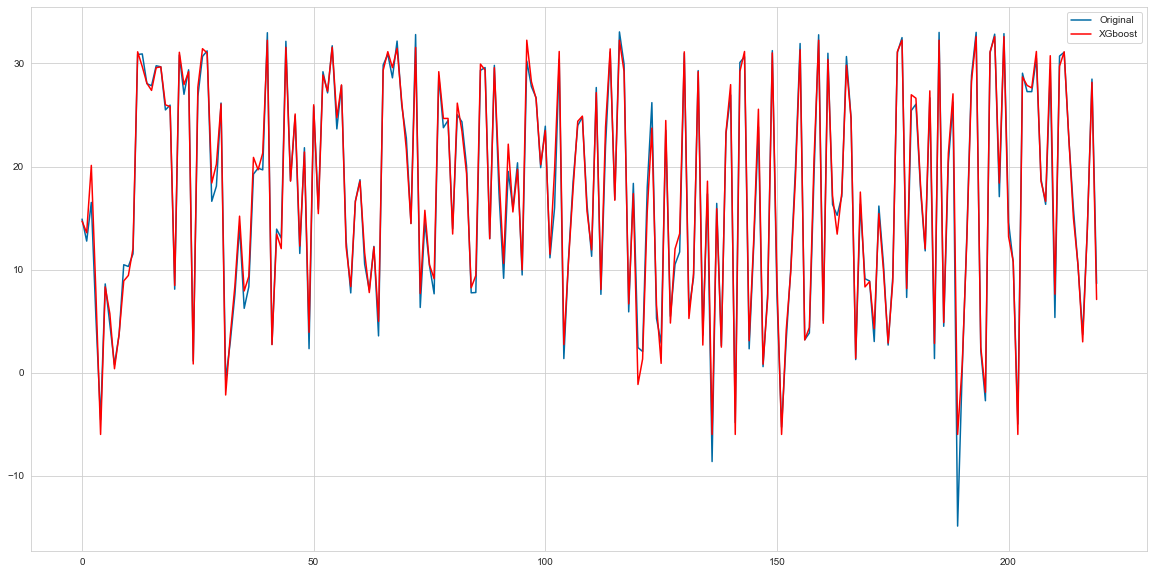

In [14]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

## Hyper Parameter Optimization

In [15]:
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(X_test)))

0.9835767230476236


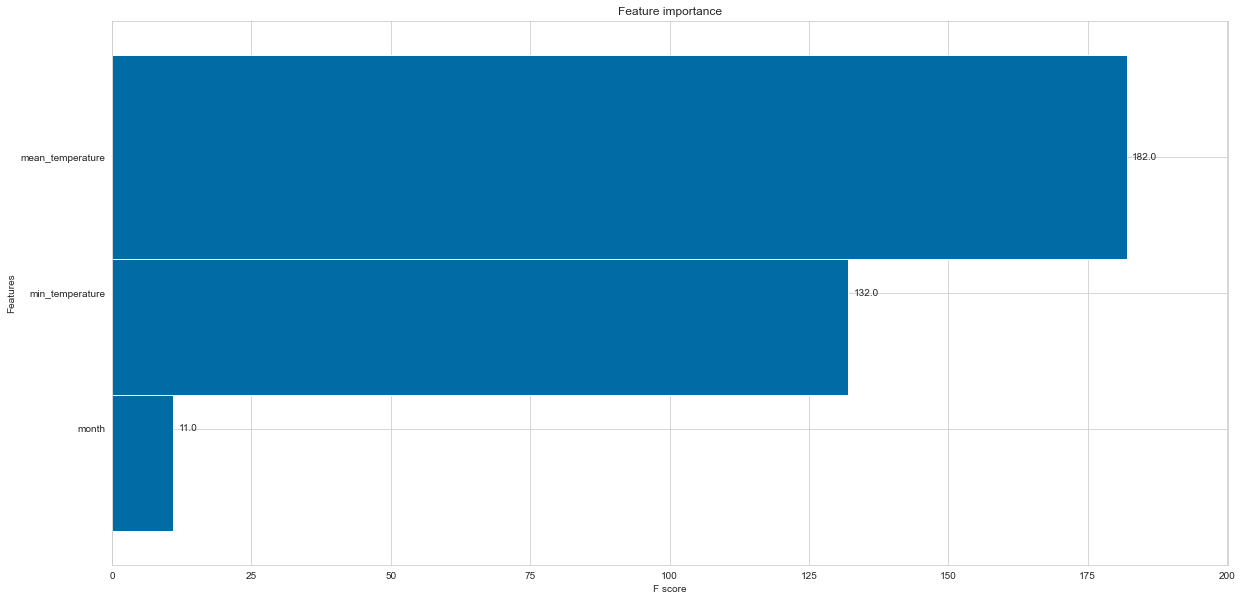

In [16]:
_ = plot_importance(gridcv_xgb, height=1.5)

In [17]:
gridcv_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0.4, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8, nthread=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
yhat = grid.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, yhat))
print("RMSE : % f" %(rmse))

RMSE :  1.387944


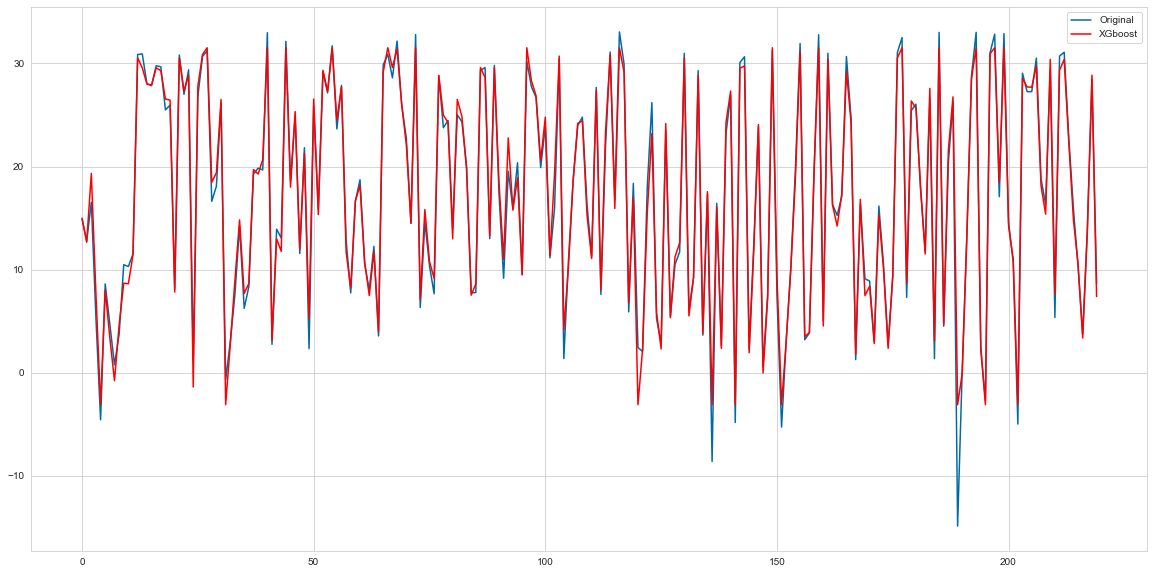

In [20]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()